稀疏化参数 epsilon = 0.1
通过调整使得最终保留 90\%的边

每个 mu 值有$50$个 SAMPLE

RAW_SCORE 这个文件中 对于每个mu值（可以看作第零个坐标）

第一个坐标是样本编号

第二个坐标是方法 ['Euclidean NMI', 'Spherical NMI', 'Euclidean ECS', 'Spherical ECS']

RAW_QF 这个文件中，对于每个mu值

其坐标是样本编号

In [1]:
#隐藏警告
import warnings
warnings.filterwarnings('ignore')

graph_type = "lfr" # "ppm" or "lfr"
embedding_method = "lap" # "lap" or "n2v"

In [2]:
if graph_type == "ppm":
    row_length = 6
    step_total  = 18
elif graph_type == "lfr":
    row_length = 5
    step_total  = 10


import pickle
import numpy as np

percent = 0.6
start_step = 0.05
step_size = 0.05
#graph_type = "lfr"
end_steps = {"lfr": 0.5, "ppm": 0.9}
end_step = end_steps[graph_type]
MU = np.around(np.arange(start_step, end_step + 0.01, step_size), decimals=2)

raw_score = {}
raw_qf = {}

delete_types = ["original", "sparse", "random"]

for delete_type in delete_types:
    raw_score[delete_type] = np.zeros((50,step_total, 4))
    raw_qf[delete_type] = np.zeros((50,step_total))
    if delete_type=='original':
        dir = f"results_{delete_type}"
    elif delete_type=="sparse":
        percent = 0.9
        dir = f"results_{delete_type}_{percent}"
    elif delete_type=="random":
        percent = 0.6
        dir = f"results_{delete_type}_{percent}"
    for mu in MU:
        mu_str = f"{mu:.2f}"
        #从文件加载 RAW_SCORE
        with open(f'{dir}/{graph_type}_{delete_type}_{embedding_method}_raw_score_mu{mu_str}.pkl', 'rb') as file:
            raw_score[delete_type][:,int(mu / step_size + 0.001) - 1,:] = pickle.load(file)
            #print(f"RAW_SCORE 已成功从文件中加载")
        with open(f'{dir}/{graph_type}_{delete_type}_{embedding_method}_raw_qf_mu{mu_str}.pkl', 'rb') as file:
            raw_qf[delete_type][:,int(mu / step_size + 0.001) - 1] = pickle.load(file)
            #print(f"RAW_QF 已成功从文件中加载")


stat = {}
for delete_type in delete_types:
    stat[delete_type] = np.zeros((step_total, 4))

for delete_type in delete_types:
    for mu in MU: 
        stat[delete_type] = np.mean(raw_score[delete_type], axis=0)

qf_proportion = np.zeros((step_total))
qf_percentile25 = np.zeros((step_total))
qf_percentile50 = np.zeros((step_total))
qf_percentile75 = np.zeros((step_total))
qf_max = np.zeros((step_total))

ratios = {}

for mu in MU:
    ratios[mu] = raw_qf['sparse'][:,int(mu / step_size + 0.001) - 1] / raw_qf['original'][:,int(mu / step_size + 0.001) - 1] 
    qf_proportion[[int(mu / step_size + 0.001) - 1]] = np.sum(ratios[mu] < 1.23)/len(ratios[mu])
    qf_percentile25[[int(mu / step_size + 0.001) - 1]] = np.percentile(ratios[mu], 25)
    qf_percentile50[[int(mu / step_size + 0.001) - 1]] = np.percentile(ratios[mu], 50)
    qf_percentile75[[int(mu / step_size + 0.001) - 1]] = np.percentile(ratios[mu], 75)
    qf_max[[int(mu / step_size + 0.001) - 1]] = np.max(ratios[mu])

def print_array_in_rows(array, row_length=row_length):
    reshaped_array = array.reshape(-1, row_length)
    for row in reshaped_array:
        print(" ".join(f"{x:.2f}" for x in row))

print("Proportion:")
print_array_in_rows(qf_proportion)

print("\n1st Quartile:")
print_array_in_rows(qf_percentile25)

print("\n2nd Quartile:")
print_array_in_rows(qf_percentile50)

print("\n3rd Quartile:")
print_array_in_rows(qf_percentile75)

print("\nMax Values:")
print_array_in_rows(qf_max)

Proportion:
0.84 0.92 1.00 1.00 1.00
1.00 1.00 1.00 1.00 1.00

1st Quartile:
1.15 1.17 1.15 1.10 1.08
1.07 1.06 1.07 1.07 1.08

2nd Quartile:
1.19 1.18 1.17 1.11 1.09
1.08 1.07 1.08 1.08 1.09

3rd Quartile:
1.22 1.20 1.18 1.12 1.10
1.08 1.07 1.09 1.08 1.09

Max Values:
1.28 1.26 1.23 1.16 1.12
1.09 1.09 1.10 1.10 1.11


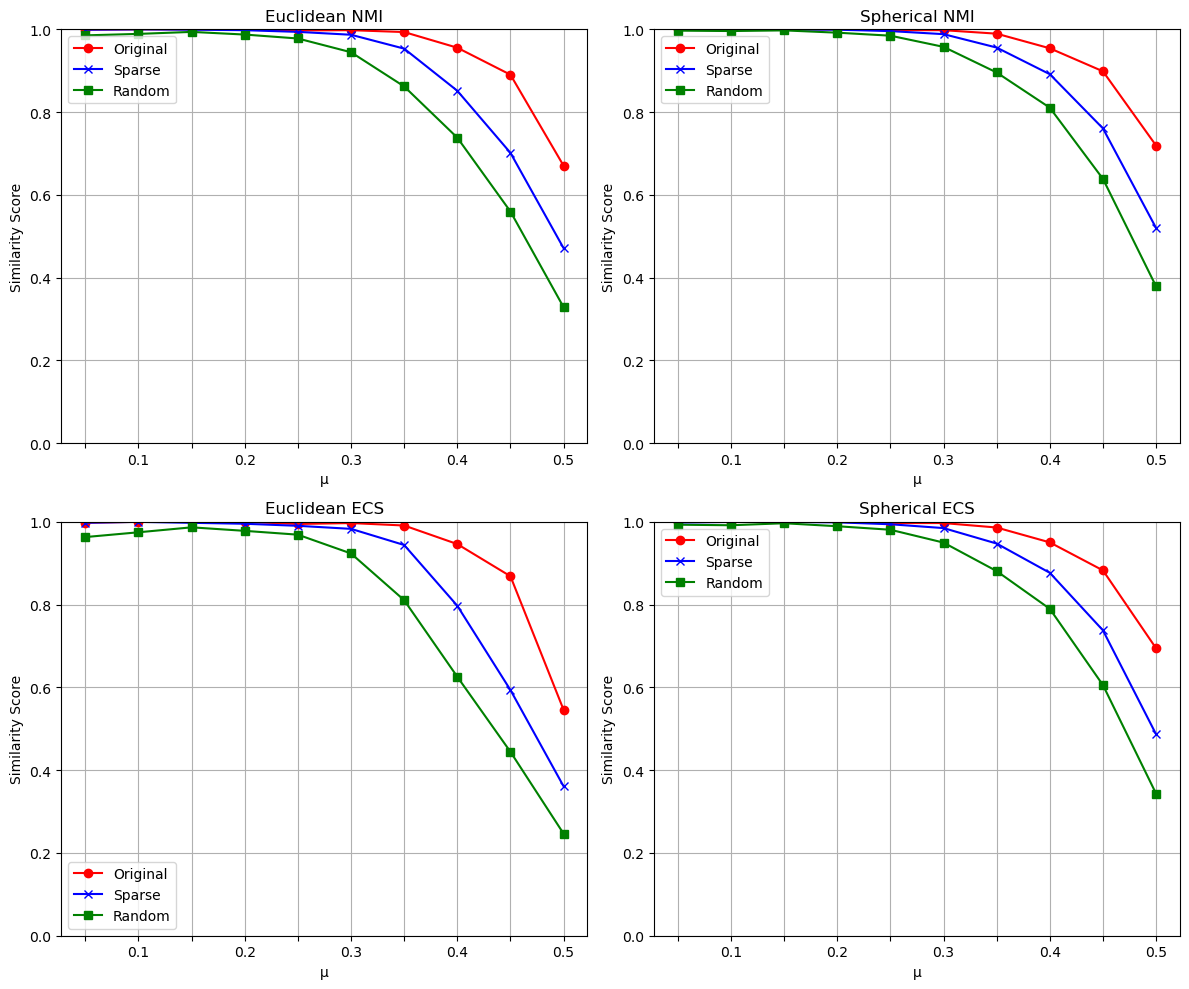

In [3]:
import numpy as np
import matplotlib.pyplot as plt


methods = [0, 1, 2, 3]
titles = ['Euclidean NMI', 'Spherical NMI', 'Euclidean ECS', 'Spherical ECS']

# 创建 2x2 网格布局
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# 绘制每个 method 的折线图
for i, method in enumerate(methods):
    ax = axs[i // 2, i % 2]
    ax.plot(stat['original'][:, method], label='Original', color='r', marker='o')  # 红色曲线
    ax.plot(stat['sparse'][:, method], label='Sparse', color='b', marker='x')  # 蓝色曲线
    ax.plot(stat['random'][:, method], label='Random', color='g', marker='s')  # 绿色曲线
    
    # 添加网格
    ax.grid(True)
    
    # 添加图例并设置位置
    ax.legend(loc='best')
    
    # 添加标签和标题
    x_labels = np.arange(0.05, (step_total+1)*step_size, 0.05)
    ax.set_xticks(np.arange(len(x_labels)))
    xticklabels = ["" if i % 2 == 1 else i/20 for i in range(1, step_total+1)]
    #ax.set_xticklabels([f'{x:.2f}' for x in x_labels])
    ax.set_xticklabels(xticklabels)
    ax.set_xlabel('μ')
    ax.set_ylabel('Similarity Score')
    ax.set_title(titles[i])
    # 设置 y 轴范围
    ax.set_ylim(0, 1)  # 这里设置 y 轴的范围为 0 到 1，可以根据实际数据调整

# 调整子图之间的间距
plt.tight_layout()

plt.savefig(f'Z_{graph_type}_{embedding_method}.png', bbox_inches='tight')

# 显示图形
plt.show()